<a href="https://colab.research.google.com/github/Mahmoud-darwish01/Project/blob/main/Project_TransferLearning_%26_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/machine vision/animal_dataset3"

 animal1_accuracy_curve.png   animal9_accuracy_curve.png
 animal2_accuracy_curve.png   animal9_loss_curve.png
 animal2_loss_curve.png       cnn1_accuracy_curve.png
 animal3_accuracy_curve.png   cnn1_loss_curve.png
 animal3_loss_curve.png       cnn2sigmoid_accuracy_curve.png
 animal4_accuracy_curve.png  'cnn2(sigmoid_loss_curve.png'
 animal4_loss_curve.png      'cnn3(TANH_accuracy_curve.png'
 animal5_accuracy_curve.png  'cnn3(TANH_loss_curve.png'
 animal5_history.pt	      cnn4_accuracy_curve.png
 animal5_loss_curve.png       cnn4_loss_curve.png
 animal5_model_40.pt	      cnn5_accuracy_curve.png
 animal5_model_41.pt	      cnn5_loss_curve.png
 animal5_model_42.pt	      cnn6_accuracy_curve.png
 animal5_model_43.pt	      cnn6_loss_curve.png
 animal5_model_44.pt	      cnn7_accuracy_curve.png
 animal5_model_45.pt	      cnn7_loss_curve.png
 animal5_model_46.pt	      cnn8_accuracy_curve.png
 animal5_model_47.pt	      cnn8_loss_curve.png
 animal5_model_48.pt	     'fine tuning2_accuracy_curve.png

In [ ]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/drive/My Drive/machine vision/animal_dataset3'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

5
{0: 'camel', 1: 'cow', 2: 'goat', 3: 'horse', 4: 'sheep'}


In [ ]:
print(idx_to_class)

{0: 'camel', 1: 'cow', 2: 'goat', 3: 'horse', 4: 'sheep'}


In [ ]:
train_data_size, valid_data_size, test_data_size

(500, 222, 222)

In [ ]:
# Load pretrained ResNet50 Model
resnet152 = models.resnet152(pretrained=True)
resnet152 = resnet152.to('cuda:0')
# Load pretrained ResNext for comparison
#resnext = models.resnext101_32x8d(pretrained=True)
#resnext = resnext.to('cuda:0')


In [ ]:

resnet152
#resnext

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet152.avgpool
#resnext.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
# modules=list(resnet152.children())[:-1]
# resnet152= nn.Sequential(*modules)

In [ ]:
# Freeze model parameters
for p in resnet152.parameters():
    p.requires_grad = False
# For the finetuning change False to True
#   p.requires_grad = True

In [ ]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet152.fc.in_features

# 2048-256-3
resnet152.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes), # Since 3 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet152 = resnet152.to('cuda:0')


In [ ]:

# Define Optimizer and Loss Function
learning_rate = 0.00001
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(resnet152.parameters(), lr = learning_rate)

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients.
            # PyTorch accumulates all the gradients in the backward pass. 
            # So it is essential to zero them out at the beginning 
            # of the training loop. 
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 50
trained_model, history = train_and_validate(resnet152, loss_func, optimizer, num_epochs)

#torch.save(history)

Epoch: 1/50
Epoch : 000, Training: Loss: 1.5304, Accuracy: 37.0000%, 
		Validation : Loss : 1.4678, Accuracy: 66.2162%, Time: 107.4723s
Epoch: 2/50
Epoch : 001, Training: Loss: 1.4482, Accuracy: 51.4000%, 
		Validation : Loss : 1.3778, Accuracy: 77.4775%, Time: 15.9259s
Epoch: 3/50
Epoch : 002, Training: Loss: 1.3625, Accuracy: 61.6000%, 
		Validation : Loss : 1.2568, Accuracy: 81.9820%, Time: 15.9233s
Epoch: 4/50
Epoch : 003, Training: Loss: 1.2251, Accuracy: 73.4000%, 
		Validation : Loss : 1.1051, Accuracy: 82.8829%, Time: 16.0024s
Epoch: 5/50
Epoch : 004, Training: Loss: 1.0960, Accuracy: 83.2000%, 
		Validation : Loss : 0.9540, Accuracy: 85.1351%, Time: 16.0808s
Epoch: 6/50
Epoch : 005, Training: Loss: 0.9654, Accuracy: 84.0000%, 
		Validation : Loss : 0.8245, Accuracy: 87.3874%, Time: 16.0807s
Epoch: 7/50
Epoch : 006, Training: Loss: 0.8481, Accuracy: 86.6000%, 
		Validation : Loss : 0.7190, Accuracy: 89.6396%, Time: 16.0742s
Epoch: 8/50
Epoch : 007, Training: Loss: 0.7026, Accur

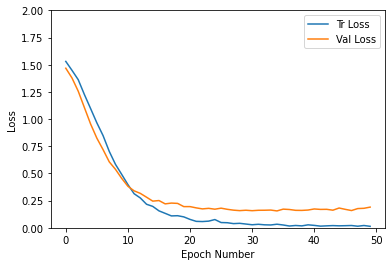

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.savefig(dataset+'fine tuning1_loss_curve.png')
plt.show()


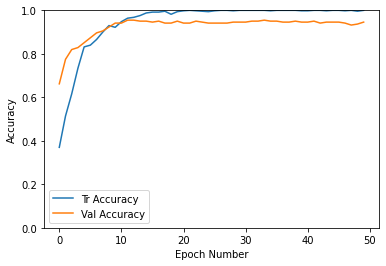

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'fine tuning1_accuracy_curve.png')
plt.show()